In [1]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mushi.utils import prf

mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [76]:
heatmap_data = []
for i, f in enumerate(glob.glob('output/*/CEU/dat.pkl')):
    population, alpha_tv, alpha_spline, ksfs = pickle.load(open(f, 'rb'))
    if alpha_tv <= 1e4 and alpha_spline <= 5e5:
        loss = float(-prf(ksfs.mu.Z.sum(1), ksfs.X.sum(1)[:-10], ksfs.L[:-10, :]))
        heatmap_data.append([alpha_tv, alpha_spline, loss, ksfs, population])

heatmap_data = np.array(heatmap_data)
heatmap_data = heatmap_data[np.lexsort(heatmap_data[:, 1::-1].T)]

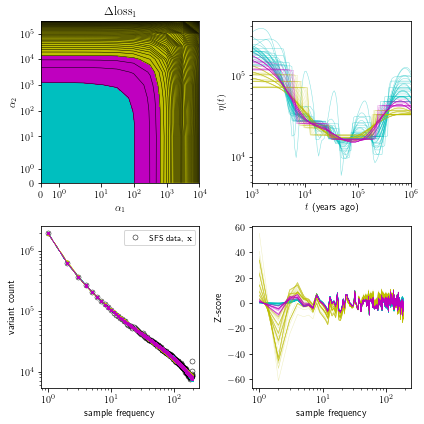

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

plt.sca(axes[0, 0])
x = np.unique(heatmap_data[:, 0])
y = np.unique(heatmap_data[:, 1])
z = heatmap_data[:, 2]
z0 = z[0]
Z = (z - z0).reshape(len(x), len(y)).T
contour = plt.contour(x, y, Z, levels=100, colors='k', linewidths=.5)
plt.contourf(contour, levels=contour.levels[:2], colors='c')
plt.contourf(contour, levels=contour.levels[1:5], colors='m')
plt.contourf(contour, levels=contour.levels[4:], colors='y')
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel(r'$\alpha_1$')
plt.ylabel(r'$\alpha_2$')
plt.title(r'$\Delta\mathrm{loss}_1$')

# human generation time
t_gen = 29

for i, data in enumerate(heatmap_data):
    alpha_tv, alpha_spline, loss, ksfs, population = data
    delta_loss = loss - z0
        
    if contour.levels[1] <= delta_loss <= contour.levels[4]:
        alpha = .9
        zorder = 2
        color = 'm'
        lw = 0.2
        rasterized = False
    elif delta_loss <= contour.levels[1]:
        alpha = .5
        zorder = 1
        color = 'c'
        lw = .5
        rasterized = True
    else:
        alpha = .25
        zorder = 1
        color = 'y'
        lw = .5
        rasterized = True

    plt.sca(axes[1, 0])
    ksfs.plot_total(kwargs=dict(alpha=0, rasterized=rasterized),
                    line_kwargs=dict(ls=':', marker='.', ms=3, alpha=alpha, zorder=zorder, lw=lw, c=color, rasterized=rasterized),
                    fill_kwargs=dict(alpha=0, rasterized=rasterized))
    plt.sca(axes[0, 1])
    ksfs.eta.plot(t_gen=t_gen, alpha=alpha, zorder=zorder, lw=lw, c=color, rasterized=rasterized)

    plt.sca(axes[1, 1])
    ξ = ksfs.L[:-10, :] @ ksfs.μ.Z.sum(1, keepdims=True)
    x = ksfs.X.sum(1, keepdims=True)[:-10]
    # Z score
    Z = (x - ξ) / np.sqrt(ξ)
    plt.plot(range(1, ksfs.n - 10), Z, alpha=alpha, zorder=zorder, lw=lw, c=color, rasterized=rasterized)


plt.sca(axes[1, 0])
ksfs.plot_total(kwargs=dict(zorder=0, ls='', alpha=1, marker='o', ms=5, mew=.5, mfc='none', c='k', label=r'SFS data, $\mathbf x$'),
                line_kwargs=dict(alpha=0),
                fill_kwargs=dict(alpha=0))
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=8, loc='upper right')

plt.sca(axes[0, 1])
plt.xlim([1e3, 1e6])

plt.sca(axes[1, 1])
plt.xlabel(r'sample frequency')
plt.xscale('log')
plt.ylabel(r'Z-score')

plt.tight_layout()
plt.savefig('eta_models.pdf')

In [82]:
np.unique(heatmap_data[:, 1])

array([0, 10, 31.622776601683793, 100, 316.22776601683796, 1000,
       3162.2776601683795, 10000, 31622.776601683792, 100000,
       316227.7660168379], dtype=object)